# Task 2

This notebook contains the code to create the predictive model for task 2 and predict the bank default.

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, roc_curve, auc, confusion_matrix
from numpy import interp
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_selection import SelectKBest, f_classif
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
random_state = 5318008

### Load the data

In [3]:
column_names = [
    "Loans for construction and land development",
    "Loans secured by farmland",
    "Loans secured by 1-4 family residential properties",
    "Loans secured by multi-family (>5) residential properties",
    "Loans secured by non-farm, non-residential properties"
    "Agricultural loans",
    "Commercial and industrial loans",
    "Loans to individuals",
    "All other loans (excl. consumer loans)",
    "Obligations (other than securities and leases) of states and political subdivisions in the US",
    "Held-to-maturity securities",
    "Available-for-sale securities total",
    "Premises and fixed assets (including capitalized leases)",
    "Cash",
    "Bank Debt",
    "Default"
]
column_names_short = [
    "L. CONSTR.",
    "L. FARM",
    "L. small res.",
    "L. big res.",
    "L. non-f. non-r."
    "L Agri.",
    "L. Commercial",
    "L. individ.",
    "L. other",
    "Obligations",
    "Held sec.",
    "For-sale sec.",
    "Fixed assets",
    "Cash",
    "Bank Debt",
    "Target"
]
file_path = "./COMP0050CourseworkData/bankPortfolios.csv"
data = pd.read_csv(file_path, header=None, names=column_names_short)

data.head()

,L. CONSTR.,L. FARM,L. small res.,L. big res.,L. non-f. non-r.L Agri.,L. Commercial,L. individ.,L. other,Obligations,Held sec.,For-sale sec.,Fixed assets,Cash,Bank Debt,Target
2699.0,6107.0,9965.0,1036.0,2924.0,3786.0,4573.0,1087.0,617.0,76.827,769.0,1828.2,381.0,933.0,32673.0,1
759920.0,6480.0,588660.0,528110.0,1188700.0,169400.0,174890.0,10210.0,6566.0,21101.000,211210.0,428740.0,82487.0,68882.0,3770300.0,1
129080.0,729.0,72972.0,3310.0,73909.0,34.0,44928.0,32995.0,409.0,502.000,15599.0,57902.0,20800.0,12168.0,423250.0,1
57828.0,1449.8,27634.0,1739.0,39274.0,1838.3,9854.0,1900.0,321.0,228.980,2291.9,7696.0,4609.0,7823.0,145830.0,1
1021.0,14222.0,3186.0,35.0,4776.0,29645.0,9295.0,3245.0,493.0,215.000,4932.0,20818.0,891.0,3661.0,87600.0,1


### Feature Engineering

In [4]:
loan_columns = [
   "L. CONSTR.",
    "L. FARM",
    "L. small res.",
    "L. big res.",
    "L. non-f. non-r."
    "L Agri.",
    "L. Commercial",
    "L. individ.",
    "L. other",
]

# Add a new feature that is the sum of all loan columns
data['Total Loans'] = data[loan_columns].sum(axis=1)

## Data Exploration

In [5]:
summary_statistics = data.describe()
corr_matrix = data.corr()
print('Number of records: ', len(data))
print(summary_statistics)

Number of records:  7783
         L. CONSTR.       L. FARM  L. small res.   L. big res.  \
count  7.783000e+03  7.783000e+03   7.783000e+03  7.783000e+03   
mean   3.180514e+04  3.929912e+05   2.378328e+04  1.585930e+05   
std    6.457248e+05  9.295027e+06   3.699621e+05  1.771229e+06   
min    0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00   
25%    8.601350e+02  6.525000e+03   3.900000e+02  4.839000e+03   
50%    2.903000e+03  1.893500e+04   1.351000e+03  1.869000e+04   
75%    8.127550e+03  5.038200e+04   4.924000e+03  5.692600e+04   
max    3.951900e+07  4.917600e+08   2.075700e+07  7.565400e+07   

       L. non-f. non-r.L Agri.  L. Commercial   L. individ.      L. other  \
count             7.783000e+03   7.783000e+03  7.783000e+03  7.783000e+03   
mean              2.881992e+04   2.062622e+05  1.736517e+05  3.633538e+04   
std               5.050626e+05   3.939996e+06  4.403195e+06  1.265055e+06   
min               0.000000e+00   0.000000e+00  2.876200e-01  0.000000e+0

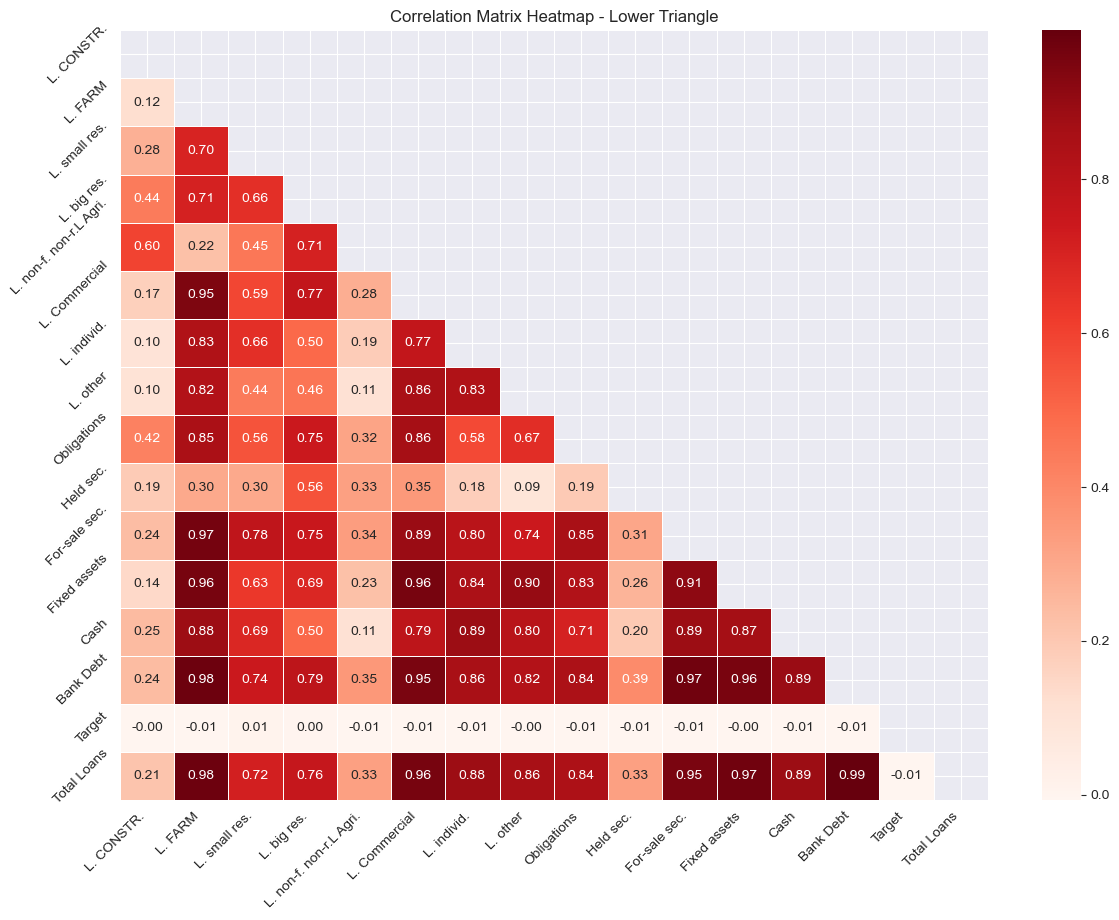

In [6]:
# Correlation matrix

# mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="Reds", cbar=True, linewidths=.5)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=45)
plt.title('Correlation Matrix Heatmap - Lower Triangle')
plt.show()

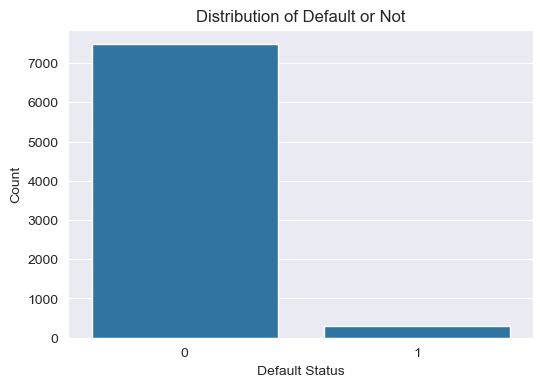

In [7]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Target', data=data)
plt.title('Distribution of Default or Not')
plt.xlabel('Default Status')
plt.ylabel('Count')
plt.show()

In [1]:
# Distribution of Selected Variables
subset_variables = [
    "L. Commercial",
    "L. FARM",
    "Fixed assets",
    "Cash",
    "Bank Debt",
]

# Distribution of the Target Variable
plt.figure(figsize=(6, 4))
plt.bar(data['Target'].value_counts().index,
        data['Target'].value_counts().values,
        color='red')
plt.title('Distribution of Default or Not')
plt.xlabel('Default Status')
plt.ylabel('Count')
plt.xticks([0, 1])
plt.show()


plt.figure(figsize=(18, 20))
for i, var in enumerate(subset_variables, 1):
    plt.subplot(5, 3, i)
    plt.hist(data[var], bins=20, color="red", alpha=0.7, density=True)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

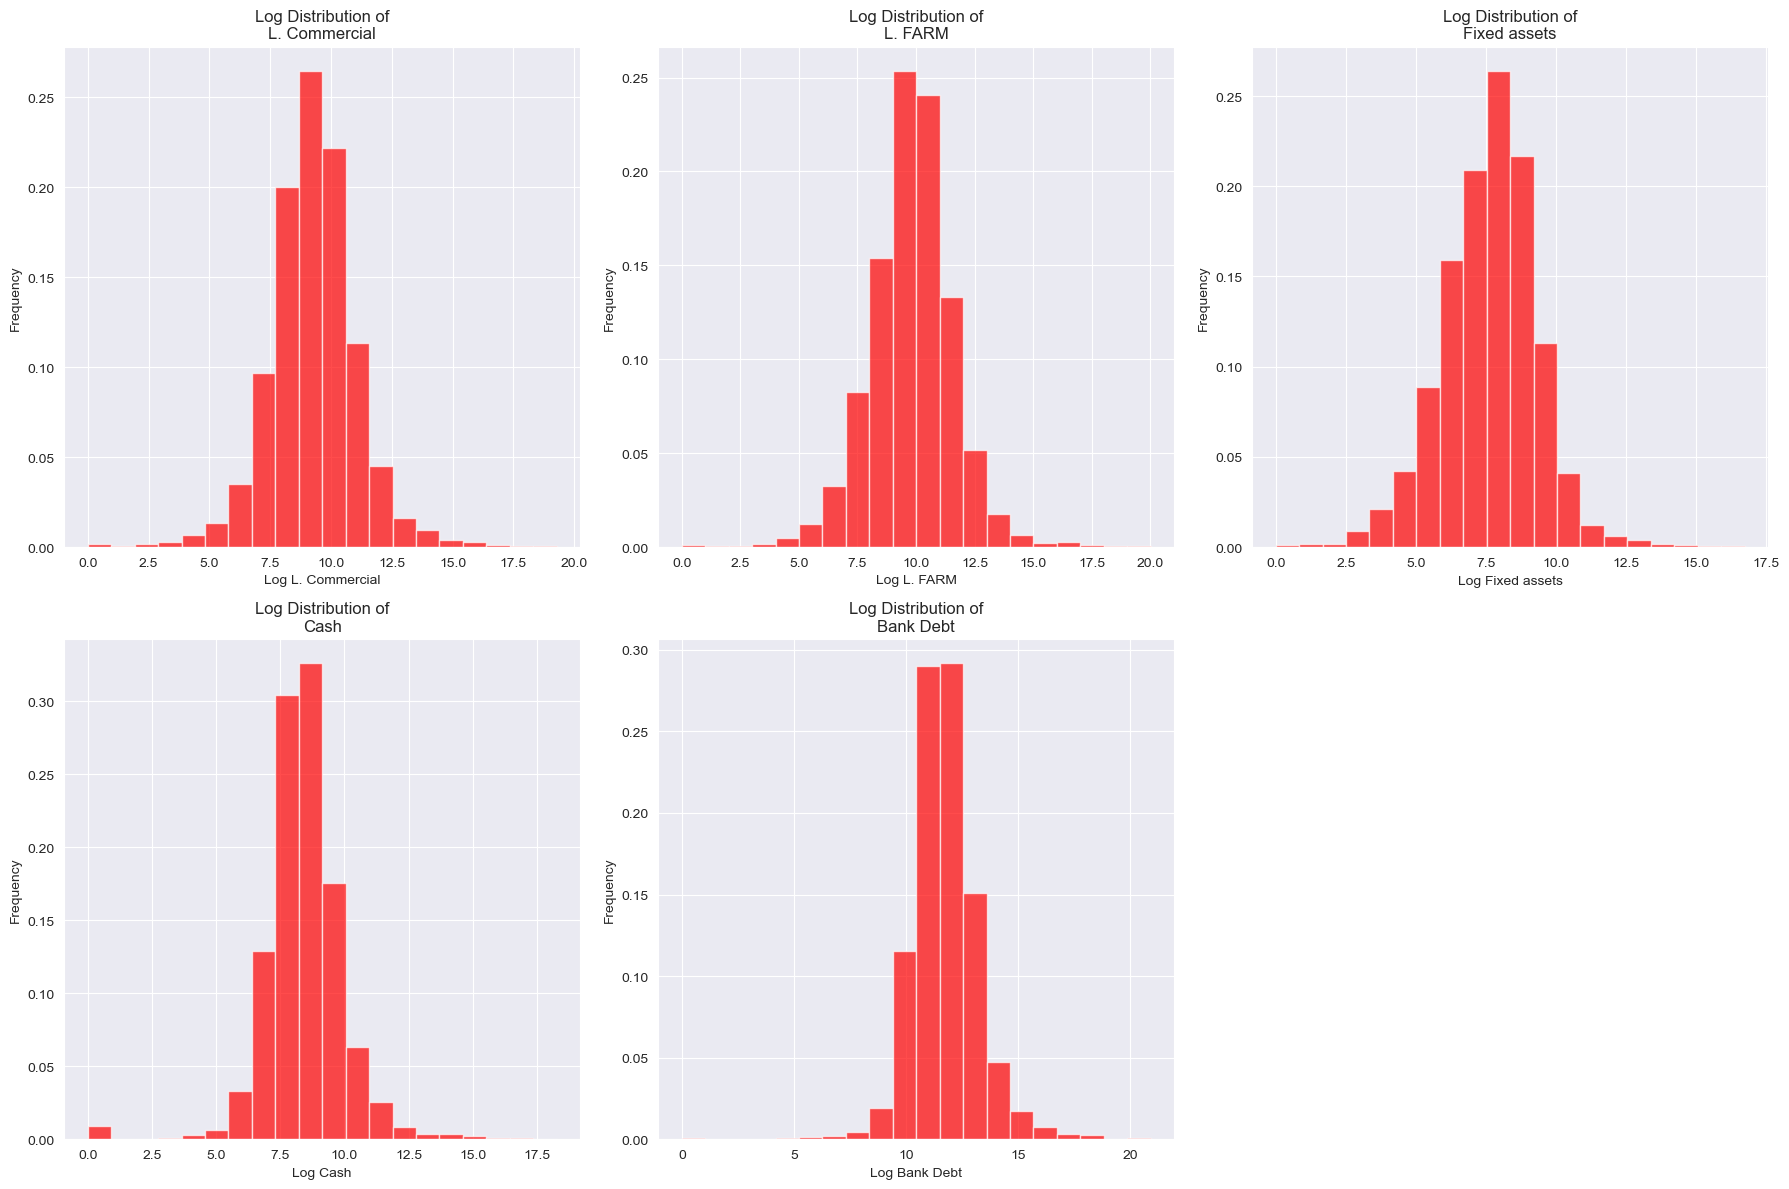

In [9]:
# log transformation to the subset of variables w a small constant (1) to avoid log(0)
log_transformed_data = data[subset_variables].apply(lambda x: np.log(x + 1))

total_plots = len(log_transformed_data.columns) + 1  # +1 for the target variable
rows = np.ceil(total_plots / 3).astype(int)
columns = 3
plt.figure(figsize=(18, 6 * rows))

# Subplots for Log-Transformed Distribution of Selected Variables
for i, column in enumerate(log_transformed_data.columns, start=1):
    plt.subplot(rows, columns, i)
    plt.hist(log_transformed_data[column], bins=20, color="red", alpha=0.7, density=True) 
    #sns.displot(log_transformed_data[column], kde=True) 
    plt.title(f'Log Distribution of\n{column}')
    plt.xlabel('Log ' + column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Data Preprocessing

In [10]:
# 1. Preparing the Data
X = data.drop('Target', axis=1)
y = data['Target']

# 2. Splitting the Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Prediction

In [13]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

In [14]:
# Definitions for plotting
colors = ['b', 'g', 'r', 'c']
plt.figure(figsize=(10, 8))

for (name, model), color in zip(models.items(), colors):
    pipeline = make_pipeline(model)
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # metrics
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1_score = f1_score(y_test, y_pred)
        
    print(f"{name} - Precision: {precision:.3f}, Recall: {recall:.3f}, ROC AUC: {roc_auc:.3f}, F1 Score: {f1_score:.3f}")
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})', color=color)

# Plot
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

TypeError: 'numpy.float64' object is not callable

<Figure size 1000x800 with 0 Axes>

### Using RobustScaler

Logistic Regression - Precision: 0.857, Recall: 0.092, ROC AUC: 0.901, F1 Score: 0.184
Decision Tree - Precision: 0.126, Recall: 0.169, ROC AUC: 0.559, F1 Score: 0.184
Random Forest - Precision: 0.000, Recall: 0.000, ROC AUC: 0.793, F1 Score: 0.184
Gradient Boosting - Precision: 0.000, Recall: 0.000, ROC AUC: 0.809, F1 Score: 0.184


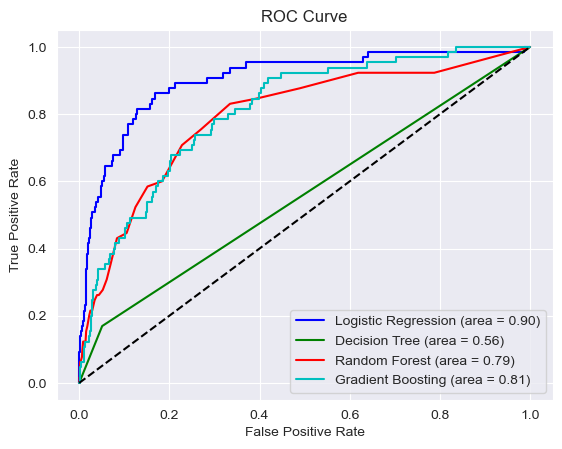

In [15]:
for (name, model), color in zip(models.items(), colors):
    # Create pipeline with robust scaler and the current model
    pipeline = make_pipeline(RobustScaler(), model)
    #pipeline = make_pipeline(model)
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
        
    # Print precision and recall
    print(f"{name} - Precision: {precision:.3f}, Recall: {recall:.3f}, ROC AUC: {roc_auc:.3f}, F1 Score: {f1_score:.3f}")

    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})', color=color)

plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Full Pipeline with Robust Scaling, SMOTE Resamplin, SelectKBest for feature selection and cross-validation

In [45]:
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=10000, C=15.3794844, solver='lbfgs'),
    "Decision Tree": DecisionTreeClassifier(criterion='gini', max_depth=8, min_samples_leaf=8),
    "Random Forest": RandomForestClassifier(criterion='gini', max_depth=15, min_samples_leaf=9, n_estimators=70),
    "Gradient Boosting": GradientBoostingClassifier(learning_rate=0.39728931, max_depth=5, n_estimators=129),
    #"XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    #"LightGBM": LGBMClassifier()  
}

'''
Best Hyperparams:
Logistic Regression:
    C= 15.3794844, solver' = 'lbfgs'
Decision Tree:
    criterion= 'gini', max_depth = 8, min_samples_leaf = 8
Random Forest:
    'criterion' = 'gini, max_depth = 15, min_samples_leaf= 9, n_estimators = 70
Gradient Boosting:
    learning_rate', 0.39728931, max_depth = 5, n_estimators = 129
'''

"\nBest Hyperparams:\nLogistic Regression:\n    C= 15.3794844, solver' = 'lbfgs'\nDecision Tree:\n    criterion= 'gini', max_depth = 8, min_samples_leaf = 8\nRandom Forest:\n    'criterion' = 'gini, max_depth = 15, min_samples_leaf= 9, n_estimators = 70\nGradient Boosting:\n    learning_rate', 0.39728931, max_depth = 5, n_estimators = 129\n"

In [46]:
# Results dictionary
results = {}

# Stratified K-Fold for imbalanced data
cv = StratifiedKFold(n_splits=3, random_state=random_state, shuffle=True)

# Scoring functions
scoring = {'recall': make_scorer(recall_score),
           'precision': make_scorer(precision_score),
           'roc_auc': make_scorer(roc_auc_score)}

threshold = 0.8

### With graphs

Running Logistic Regression...
Running Logistic Regression...
Running Logistic Regression...
Running Decision Tree...
Running Decision Tree...
Running Decision Tree...
Running Random Forest...
Running Random Forest...
Running Random Forest...
Running Gradient Boosting...
Running Gradient Boosting...
Running Gradient Boosting...


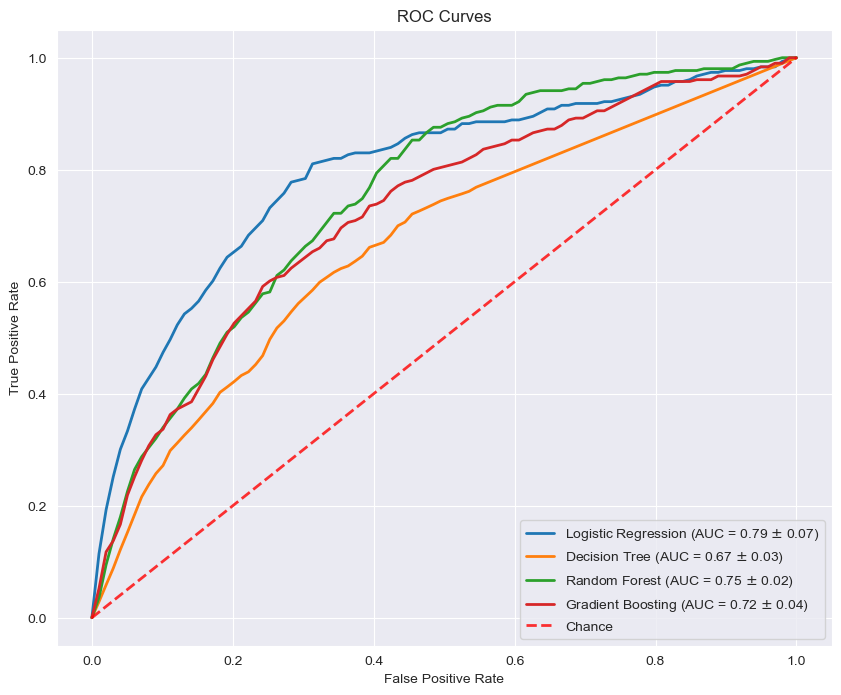

Logistic Regression: Precision: 0.2771, Recall: 0.1961, F1 Score: 0.2271, ROC AUC: 0.7933
Decision Tree: Precision: 0.1044, Recall: 0.2680, F1 Score: 0.1492, ROC AUC: 0.6681
Random Forest: Precision: 0.1306, Recall: 0.0261, F1 Score: 0.0435, ROC AUC: 0.7547
Gradient Boosting: Precision: 0.1473, Recall: 0.1405, F1 Score: 0.1438, ROC AUC: 0.7240


In [49]:
metrics_results = {}
plt.figure(figsize=(10, 8))
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []


for name, classifier in classifiers.items():
    pipeline = ImbPipeline(steps=[
        ('feature_selection', SelectKBest(f_classif, k=10)),
        ('oversample', SMOTE()),
        ('scaler', RobustScaler()),
        #('scaler', StandardScaler()),
        ('classifier', classifier)
    ])
    
    # Lists to store metrics for each fold
    precisions = []
    recalls = []
    f1s = []
    aucs = []
    tprs = []
    
    for train, test in cv.split(X, y):
        print(f"Running {name}...")
        model = pipeline.fit(X.iloc[train], y.iloc[train])
        y_pred = model.predict(X.iloc[test])
        y_proba = model.predict_proba(X.iloc[test])[:, 1]
        y_pred = np.where(y_proba > threshold, 1, 0)
        
        # Calculate metrics
        pre = precision_score(y.iloc[test], y_pred, zero_division=0)
        precisions.append(pre)
        recall = recall_score(y.iloc[test], y_pred, zero_division=0)
        recalls.append(recall)
        f1 = 2 * (pre * recall) / (pre + recall) if (pre + recall) > 0 else 0
        f1s.append(f1)
        
        # ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y.iloc[test], y_proba)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    # Average the metrics
    metrics_results[name] = {
        'Precision': np.mean(precisions),
        'Recall': np.mean(recalls),
        'F1 Score': np.mean(f1s),
        'ROC AUC': np.mean(aucs),
    }
    
    # Plot the ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, label=r'%s (AUC = %0.2f $\pm$ %0.2f)' % (name, mean_auc, std_auc), lw=2)

# Plot formatting 
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

# average precision, recall, and F1 score
for model, scores in metrics_results.items():
    print(f"{model}: Precision: {scores['Precision']:.4f}, Recall: {scores['Recall']:.4f}, F1 Score: {scores['F1 Score']:.4f}, ROC AUC: {scores['ROC AUC']:.4f}")


## FINAL RESULTS
Baseline model, no scaling, no feature selection, no resampling
    Logistic Regression: Precision: 0.4076, Recall: 0.0654, F1 Score: 0.1121, ROC AUC: 0.8174
    Decision Tree: Precision: 0.1046, Recall: 0.1176, F1 Score: 0.1107, ROC AUC: 0.5382
    Random Forest: Precision: 0.3333, Recall: 0.0033, F1 Score: 0.0065, ROC AUC: 0.7659
    Gradient Boosting: Precision: 0.1616, Recall: 0.0196, F1 Score: 0.0349, ROC AUC: 0.7818
    
Model + Robust Scaling
    Logistic Regression: Precision: 0.4187, Recall: 0.0654, F1 Score: 0.1125, ROC AUC: 0.8185
    Decision Tree: Precision: 0.0921, Recall: 0.1078, F1 Score: 0.0993, ROC AUC: 0.5321
    Random Forest: Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, ROC AUC: 0.7802
    Gradient Boosting: Precision: 0.1756, Recall: 0.0196, F1 Score: 0.0352, ROC AUC: 0.7820
Model + Standard Scaling: 
    Logistic Regression: Precision: 0.0833, Recall: 0.0033, F1 Score: 0.0063, ROC AUC: 0.7112
    Decision Tree: Precision: 0.1011, Recall: 0.1176, F1 Score: 0.1087, ROC AUC: 0.5374
    Random Forest: Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, ROC AUC: 0.7638
    Gradient Boosting: Precision: 0.1048, Recall: 0.0131, F1 Score: 0.0232, ROC AUC: 0.7828

Model + Robust Scaling + Oversampling:
    Logistic Regression: Precision: 0.1895, Recall: 0.6013, F1 Score: 0.2880, ROC AUC: 0.8294
    Decision Tree: Precision: 0.1032, Recall: 0.2876, F1 Score: 0.1517, ROC AUC: 0.5922
    Random Forest: Precision: 0.1666, Recall: 0.1667, F1 Score: 0.1662, ROC AUC: 0.7662
    Gradient Boosting: Precision: 0.1127, Recall: 0.5261, F1 Score: 0.1856, ROC AUC: 0.7646
    
Model + Robust Scaling + Oversampling + Hyperparameters:
    Logistic Regression: Precision: 0.3283, Recall: 0.3497, F1 Score: 0.3382, ROC AUC: 0.8340
    Decision Tree: Precision: 0.1068, Recall: 0.2353, F1 Score: 0.1410, ROC AUC: 0.6767
    Random Forest: Precision: 0.2907, Recall: 0.0294, F1 Score: 0.0523, ROC AUC: 0.7730
    Gradient Boosting: Precision: 0.2163, Recall: 0.1634, F1 Score: 0.1854, ROC AUC: 0.7493

Model + Standard Scaling + Oversampling:
    Logistic Regression: Precision: 0.1070, Recall: 0.4477, F1 Score: 0.1722, ROC AUC: 0.7447
    Decision Tree: Precision: 0.0999, Recall: 0.2843, F1 Score: 0.1479, ROC AUC: 0.5897
    Random Forest: Precision: 0.1663, Recall: 0.1634, F1 Score: 0.1647, ROC AUC: 0.7706
    Gradient Boosting: Precision: 0.1053, Recall: 0.4902, F1 Score: 0.1734, ROC AUC: 0.7577

Model + Standard Scaling + Feature Selection + Oversampling:
    Logistic Regression: Precision: 0.1374, Recall: 0.4542, F1 Score: 0.2110, ROC AUC: 0.7674
    Decision Tree: Precision: 0.1049, Recall: 0.2876, F1 Score: 0.1537, ROC AUC: 0.5934
    Random Forest: Precision: 0.1412, Recall: 0.1928, F1 Score: 0.1629, ROC AUC: 0.7521
    Gradient Boosting: Precision: 0.1014, Recall: 0.5163, F1 Score: 0.1694, ROC AUC: 0.7478

Model + Robust Scaling + Feature Selection + Oversampling:
    Logistic Regression: Precision: 0.1555, Recall: 0.5654, F1 Score: 0.2435, ROC AUC: 0.7914
    Decision Tree: Precision: 0.0858, Recall: 0.2484, F1 Score: 0.1273, ROC AUC: 0.5708
    Random Forest: Precision: 0.1298, Recall: 0.1797, F1 Score: 0.1507, ROC AUC: 0.7515
    Gradient Boosting: Precision: 0.1019, Recall: 0.5425, F1 Score: 0.1714, ROC AUC: 0.7515
    
Model + Robust Scaling + Feature Selection + Oversampling + Hyperparameters:
    Logistic Regression: Precision: 0.2771, Recall: 0.1961, F1 Score: 0.2271, ROC AUC: 0.7933
    Decision Tree: Precision: 0.1044, Recall: 0.2680, F1 Score: 0.1492, ROC AUC: 0.6681
    Random Forest: Precision: 0.1306, Recall: 0.0261, F1 Score: 0.0435, ROC AUC: 0.7547
    Gradient Boosting: Precision: 0.1473, Recall: 0.1405, F1 Score: 0.1438, ROC AUC: 0.7240



### Feature Importance

In [ ]:

# Selecting features using SelectKBest for the entire dataset for illustration
selector = SelectKBest(f_classif, k=8)
X_new = selector.fit_transform(X, y)

# Get the indices of the selected features
selected_indices = selector.get_support(indices=True)
selected_features = [X.columns[i] for i in selected_indices]

print("Selected features:", selected_features)

### ADDING HYPERPARAMETER TUNING

Running Logistic Regression...
Logistic Regression - Precision: 0.3725, Recall: 0.2923, F1: 0.1468, ROC AUC: 0.8850
Best hyperparameters: OrderedDict([('classifier__C', 11.533999859559563), ('classifier__solver', 'liblinear')])
Running Decision Tree...
Decision Tree - Precision: 0.1484, Recall: 0.2923, F1: 0.1468, ROC AUC: 0.6922
Best hyperparameters: OrderedDict([('classifier__criterion', 'gini'), ('classifier__max_depth', 9), ('classifier__min_samples_leaf', 2)])
Running Random Forest...
Random Forest - Precision: 0.1000, Recall: 0.0154, F1: 0.0266, ROC AUC: 0.7772
Best hyperparameters: OrderedDict([('classifier__criterion', 'entropy'), ('classifier__max_depth', 19), ('classifier__min_samples_leaf', 2), ('classifier__n_estimators', 46)])
Running Gradient Boosting...
Gradient Boosting - Precision: 0.2143, Recall: 0.2308, F1: 0.1376, ROC AUC: 0.7685
Best hyperparameters: OrderedDict([('classifier__learning_rate', 0.42149456283334996), ('classifier__max_depth', 3), ('classifier__n_estim

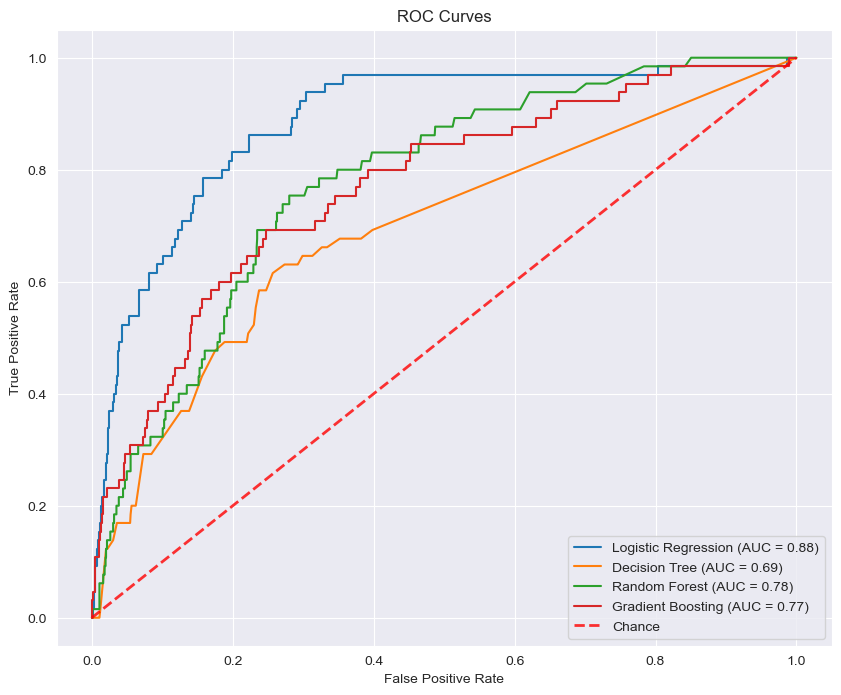

In [50]:

# Splitting the data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

bayes_hyperparameters = {
    "Logistic Regression": {
        'classifier__C': Real(0.001, 100, prior='log-uniform'),
        'classifier__solver': Categorical(['liblinear', 'lbfgs'])
    },
    "Decision Tree": {
        'classifier__max_depth': Integer(1, 10),
        'classifier__min_samples_leaf': Integer(1, 10),
        'classifier__criterion': Categorical(['gini', 'entropy'])
    },
    "Random Forest": {
        'classifier__n_estimators': Integer(10, 200),
        'classifier__max_depth': Integer(1, 20),
        'classifier__min_samples_leaf': Integer(1, 10),
        'classifier__criterion': Categorical(['gini', 'entropy'])
    },
    "Gradient Boosting": {
        'classifier__n_estimators': Integer(50, 200),
        'classifier__learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'classifier__max_depth': Integer(1, 10)
    },
    "MLP Neural Network": {
        'classifier__hidden_layer_sizes': Categorical([(50,), (100,), (50, 50), (100, 100)]),
        'classifier__activation': Categorical(['tanh', 'relu']),
        'classifier__alpha': Real(1e-4, 1e-1, 'log-uniform'),
        'classifier__learning_rate_init': Real(1e-4, 1e-1, 'log-uniform')
    }}

plt.figure(figsize=(10, 8))
mean_fpr = np.linspace(0, 1, 100)

for name, classifier in classifiers.items():
    print(f"Running {name}...")

    pipeline = ImbPipeline(steps=[
        ('feature_selection', SelectKBest(f_classif, k=10)),
        ('oversample', SMOTE()),
        ('scaler', RobustScaler()),
        ('classifier', classifier)
    ])
    
    # Select the hyperparameter space
    param_space = bayes_hyperparameters[name]
    
    # Setup BayesSearchCV
    opt = BayesSearchCV(pipeline, param_space, n_iter=10, cv=3, scoring='f1', return_train_score=False, n_jobs=-1, random_state=42)
    
    # Perform the search on the training data
    opt.fit(X_train, y_train)
    
    # Evaluate on the validation set
    best_model = opt.best_estimator_
    y_proba = best_model.predict_proba(X_val)[:, 1]
    y_pred = np.where(y_proba > threshold, 1, 0)  # Apply the threshold
    
     # Calculate confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    
    # Calculate and print metrics
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    f1 = 2 * (pre * recall) / (pre + recall) if (pre + recall) > 0 else 0
    roc_auc = roc_auc_score(y_val, y_proba)
    
    print(f"{name} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc:.4f}")
    print(f"Best hyperparameters: {opt.best_params_}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot formatting for the ROC curve
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()


## AUTOML TEST

In [ ]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

# Convert your dataset to an H2O Frame
h2o_df = h2o.H2OFrame(data)
# Split the data into train and test sets
train, test = h2o_df.split_frame(ratios=[.8], seed=42)

# Identify predictors and target
x_h2o = train.columns
y_h2o = "Target" 
x_h2o.remove(y_h2o)

# For classification, ensure the target is a factor
train[y_h2o] = train[y_h2o].asfactor()
test[y_h2o] = test[y_h2o].asfactor()

# Initialize and train the H2OAutoML model
aml = H2OAutoML(max_runtime_secs=300, seed=1, project_name="bank_default_prediction")
aml.train(x=x_h2o, y=y_h2o, training_frame=train)

# View the AutoML Leaderboard
lb = aml.leaderboard
print(lb.head(rows=lb.nrows))  # Print all rows instead of default (10 rows)

# Predict on the test set
preds = aml.leader.predict(test)

# Evaluate performance
perf = aml.leader.model_performance(test)
print(perf)


## PCA Visualisation

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Initialize PCA, reducing to two dimensions
pca = PCA(n_components=2)

# Fit and transform the features to two dimensions
X_pca = pca.fit_transform(X_scaled)

# Plotting
plt.figure(figsize=(10, 8))

# Plot each class with a different shape
for target_class in [0, 1]:
    plt.scatter(X_pca[y == target_class, 0],  # x-axis: first principal component
                X_pca[y == target_class, 1],  # y-axis: second principal component
                alpha=0.5, 
                label=f'Class {target_class}',
                marker='o' if target_class == 0 else 's')  # Different shapes for different classes

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('2D PCA Visualization')
plt.legend()
plt.show()


In [ ]:
# Nearest Neighbours classifier on PCA data ---> SHIT
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

# Standardize before PCA
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_scaled)

# Split the PCA-transformed data
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# K-Nearest Neighbors classifier
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train_pca, y_train)

# Predict test
y_pred = knn.predict(X_test_pca)
y_proba = knn.predict_proba(X_test_pca)[:, 1] 

# performance metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
